In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from prophet import Prophet
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import date,datetime, timedelta
import seaborn as sns
# Returns the current local date
today = date.today()

**PROPHET MODELLING**

[*********************100%***********************]  1 of 1 completed


15:16:47 - cmdstanpy - INFO - Chain [1] start processing
15:16:50 - cmdstanpy - INFO - Chain [1] done processing


Combined Data for AMPH:
╒══════╤═════════════════════╤════════╤════════╤═══════╤═══════╤═════════════╤══════════╤════════════╤═════════════════════╤═══════════════╤═══════════════╤════════════╤═══════╤════════╤════════╕
│      │ ds                  │   Open │   High │   Low │     y │   Adj Close │   Volume │   Forecast │ Forecast Date       │   Lower Bound │   Upper Bound │   Accuracy │   MAE │    MSE │   RMSE │
╞══════╪═════════════════════╪════════╪════════╪═══════╪═══════╪═════════════╪══════════╪════════════╪═════════════════════╪═══════════════╪═══════════════╪════════════╪═══════╪════════╪════════╡
│ 2227 │ 2023-05-17 00:00:00 │  43.10 │  43.22 │ 42.20 │ 42.97 │       42.97 │   544600 │     nan    │ NaT                 │        nan    │        nan    │     nan    │  9.63 │ 130.47 │  11.42 │
├──────┼─────────────────────┼────────┼────────┼───────┼───────┼─────────────┼──────────┼────────────┼─────────────────────┼───────────────┼───────────────┼────────────┼───────┼────────┼──────

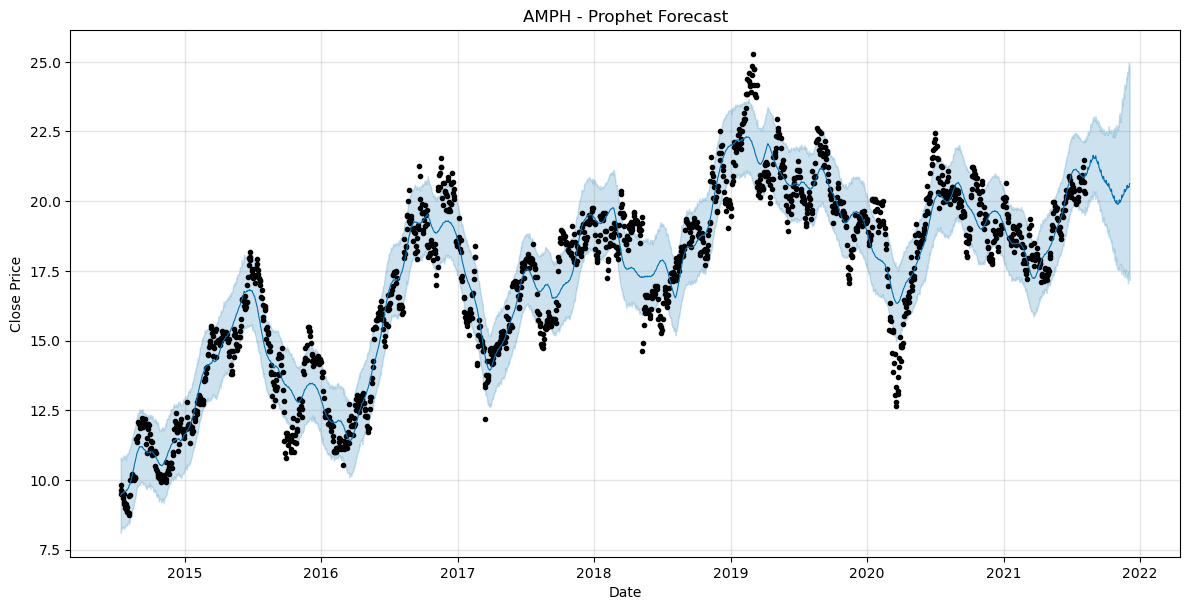

Average Accuracies:
AMPH: 70.60%


In [15]:
class StockDataRetriever:
    """
    Class for retrieving stock data from Yahoo Finance.
    """

    def __init__(self, ticker, start_date, end_date):
        """
        Initialize the StockDataRetriever class.

        Parameters:
        - ticker (str): Ticker symbol of the stock.
        - start_date (str): Start date of the historical data in the format 'YYYY-MM-DD'.
        - end_date (str): End date of the historical data in the format 'YYYY-MM-DD'.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date

    def fetch_data(self):
        """
        Fetch stock data from Yahoo Finance.

        Returns:
        - data (pd.DataFrame): DataFrame containing the stock data.
        """
        data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        return data


class StockForecaster:
    """
    Class for performing stock forecasting using Prophet.
    """

    def __init__(self, ticker, start_date, end_date, train_ratio=0.8):
        """
        Initialize the StockForecaster class.

        Parameters:
        - ticker (str): Ticker symbol of the stock.
        - start_date (str): Start date of the historical data in the format 'YYYY-MM-DD'.
        - end_date (str): End date of the historical data in the format 'YYYY-MM-DD'.
        - train_ratio (float): Ratio of data to be used for training. Default is 0.8 (80%).
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.train_ratio = train_ratio
        self.data = None
        self.train_data = None
        self.test_data = None
        self.model = None

    def fetch_data(self):
        """
        Fetch stock data using the StockDataRetriever class.
        """
        data_retriever = StockDataRetriever(self.ticker, self.start_date, self.end_date)
        self.data = data_retriever.fetch_data()

    def prepare_data(self):
        """
        Prepare the stock data for forecasting.
        """
        self.data = self.data.reset_index()
        self.data = self.data.rename(columns={'Date': 'ds', 'Close': 'y'})

    def clean_outliers(self):
        """
        Clean outliers from the stock data.
        """
        # Calculate the z-score for each data point
        z_scores = (self.data['y'] - self.data['y'].mean()) / self.data['y'].std()

        # Set a threshold for outlier detection (e.g., z-score > 3)
        threshold = 3

        # Remove outliers from the data
        self.data = self.data[abs(z_scores) <= threshold]

    def split_data(self):
        """
        Split the stock data into training and testing sets.
        """
        split_index = int(self.train_ratio * len(self.data))
        self.train_data = self.data[self.data['ds'] <= self.data['ds'][split_index]]
        self.test_data = self.data[self.data['ds'] > self.data['ds'][split_index]]

    def train_model(self):
        """
        Train the Prophet model.
        """
        if self.train_data is None or self.train_data['y'].count() < 2:
            raise ValueError('Insufficient data for training the model.')

        self.model = Prophet(changepoint_prior_scale=1, daily_seasonality=True)
        self.model.fit(self.train_data)

    def evaluate_model(self):
        """
        Evaluate the performance of the trained model.
        """
        if self.model is None or self.test_data is None or self.test_data.empty:
            raise ValueError('Model or test data is not available.')

        # Perform predictions on the test data
        future_dates = self.model.make_future_dataframe(periods=len(self.test_data))
        predictions = self.model.predict(future_dates)

        # Calculate forecasting accuracy on the test data
        accuracy = 100 * (1 - abs(self.test_data['y'] - predictions['yhat'][-len(self.test_data):]) / self.test_data['y'])
        average_accuracy = accuracy.mean()

        # Calculate additional evaluation metrics
        mae = mean_absolute_error(self.test_data['y'], predictions['yhat'][-len(self.test_data):])
        mse = mean_squared_error(self.test_data['y'], predictions['yhat'][-len(self.test_data):])
        rmse = np.sqrt(mse)

        # Combine the test data, predictions, accuracy, and performance metrics into a single table
        combined_table = self.test_data.copy()
        combined_table['Forecast'] = predictions['yhat'][-len(self.test_data):]
        combined_table['Forecast Date'] = predictions['ds'][-len(self.test_data):]
        combined_table['Lower Bound'] = predictions['yhat_lower'][-len(self.test_data):]
        combined_table['Upper Bound'] = predictions['yhat_upper'][-len(self.test_data):]
        combined_table['Accuracy'] = accuracy
        combined_table['MAE'] = mae
        combined_table['MSE'] = mse
        combined_table['RMSE'] = rmse

        # Sort the table by date in descending order
        combined_table = combined_table.sort_values(by='ds', ascending=False)

        # Print the combined table with the actual values, forecasted values, accuracy, and performance metrics
        print(f'Combined Data for {self.ticker}:')
        table = tabulate(combined_table, headers='keys', tablefmt='fancy_grid', floatfmt='.2f')
        print(table)

        return combined_table, average_accuracy

    def plot_forecast(self):
        """
        Plot the stock forecast using Prophet.
        """
        future_dates = self.model.make_future_dataframe(periods=120)
        predictions = self.model.predict(future_dates)

        fig, ax = plt.subplots(figsize=(12, 6))
        self.model.plot(predictions, ax=ax)
        ax.set_xlabel('Date')
        ax.set_ylabel('Close Price')
        ax.set_title(f'{self.ticker} - Prophet Forecast')
        lines = ax.get_lines()
        forecast_line = lines[-1]
        forecast_line.set_linewidth(0.8)  # Adjust the linewidth here
        plt.show()

        return predictions['yhat']


def perform_forecasting(start_date, end_date, train_ratio=0.8):
    """
    Perform stock forecasting for multiple tickers.

    Parameters:
    - start_date (str): Start date of the historical data in the format 'YYYY-MM-DD'.
    - end_date (str): End date of the historical data in the format 'YYYY-MM-DD'.
    - train_ratio (float): Ratio of data to be used for training. Default is 0.8 (80%).

    Returns:
    - average_accuracies (dict): Dictionary of average accuracies for each ticker.
    """
    tickers = input("Enter ticker symbols (comma-separated): ").split(",")
    tickers = [ticker.strip().upper() for ticker in tickers]

    all_predictions = []
    average_accuracies = {}

    for ticker in tickers:
        forecaster = StockForecaster(ticker, start_date, end_date, train_ratio)
        forecaster.fetch_data()
        forecaster.prepare_data()
        forecaster.clean_outliers()
        forecaster.split_data()

        if forecaster.data is None or forecaster.data['y'].count() < 2:
            print(f'Insufficient data for {ticker}. Skipping forecasting.')
            continue

        forecaster.train_model()
        table, average_accuracy = forecaster.evaluate_model()
        average_accuracies[ticker] = average_accuracy

        # Plot the forecast for the current ticker
        predicted_values = forecaster.plot_forecast()
        all_predictions.append(predicted_values)

    # Combine the forecasted values into a single DataFrame
    combined_df = pd.concat(all_predictions, axis=1)
    combined_df.columns = tickers

    # Calculate the correlation matrix
    correlation_matrix = combined_df.corr()

    # Plot the correlation matrix as a heatmap with customized colors
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    #plt.title('Correlation Matrix of Tickers')
    #plt.show()

    return average_accuracies


# Example usage:

end_date = pd.to_datetime('today')
start_date = pd.to_datetime('today') - pd.DateOffset(years=9)
train_ratio = 0.8
average_accuracies = perform_forecasting(start_date, end_date, train_ratio)

# Print the average accuracies
print('Average Accuracies:')
for ticker, accuracy in average_accuracies.items():
    print(f'{ticker}: {accuracy:.2f}%')

**PLOT ONLY FORECAST AFTER TODAY**

In [ ]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
from datetime import datetime
import plotly.graph_objects as go

# Fixed start and end dates
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Get the current date in 'YYYY-MM-DD' format

# Prompt the user to enter the ticker symbol
ticker = input("Enter the ticker symbol (e.g., AAPL): ")

# Retrieve the historical data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Reset the index to make the 'Date' column accessible
data.reset_index(inplace=True)

# Select the 'Date' and 'Close' columns for analysis
df = data[['Date', 'Close']].copy()
df.columns = ['ds', 'y']  # Rename columns to 'ds' and 'y'

# Create a Prophet model and fit it to the data
model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.05)
model.fit(df)

# Create future dates for forecasting
future = model.make_future_dataframe(periods=365)

# Perform the forecasting
forecast = model.predict(future)

# Get the future dates after today
today = datetime.today().strftime('%Y-%m-%d')
future_dates = forecast[forecast['ds'] > today]

# Create an interactive plot using Plotly
fig = go.Figure()

# Add the forecasted line trace
fig.add_trace(go.Scatter(x=future_dates['ds'], y=future_dates['yhat'], mode='lines', name='Forecast'))

# Set plot layout
fig.update_layout(
    title=f'{ticker} Stock Price Forecast (After Today)',
    xaxis_title='Date',
    yaxis_title='Price'
)

# Show the interactive plot
fig.show()


**TICKER COMPARISON PLOT** 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


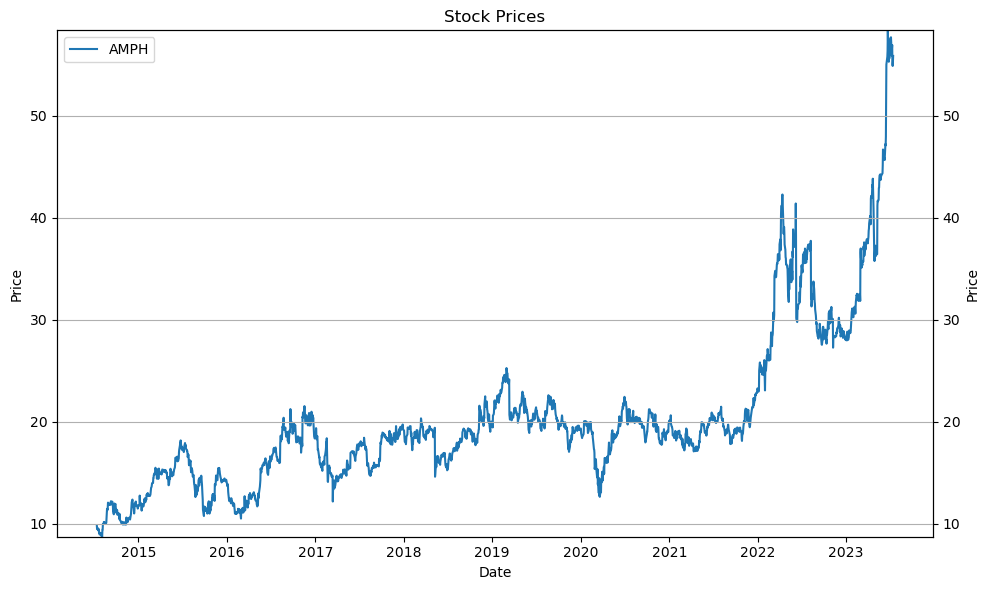

In [19]:
import yfinance as yf
import matplotlib.pyplot as plt

def plot_stock_prices(tickers, start_date, end_date):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)
        ax1.plot(data.index, data['Close'], label=ticker)

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Set the second y-axis label
    ax2.set_ylabel('Price')

    min_price = float('inf')
    max_price = float('-inf')

    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)
        min_price = min(min_price, data['Close'].min())
        max_price = max(max_price, data['Close'].max())

    # Set the y-axis limits based on the minimum and maximum prices
    ax1.set_ylim(min_price, max_price)
    ax2.set_ylim(min_price, max_price)

    plt.title('Stock Prices')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
tickers = input("Enter ticker symbols (comma-separated): ").split(",")
tickers = [ticker.strip().upper() for ticker in tickers]
end_date = pd.to_datetime('today')
start_date = pd.to_datetime('today') - pd.DateOffset(years=9)

plot_stock_prices(tickers, start_date, end_date)


**NO TRAIN DATA + NO OUTLIER REMOVAL**


[*********************100%***********************]  1 of 1 completed


15:20:24 - cmdstanpy - INFO - Chain [1] start processing
15:20:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 2.03
Mean Squared Error (MSE): 7.95
Root Mean Squared Error (RMSE): 2.82
             ds       yhat  yhat_lower  yhat_upper
2412 2023-12-07  46.547830   42.981690   50.240971
2413 2023-12-08  46.613506   43.003665   50.198282
2414 2023-12-09  46.496616   42.899865   50.000130
2415 2023-12-10  46.526543   43.041793   50.237259
2416 2023-12-11  46.640818   43.200721   50.291317
+----------------------------------------+---------------------+
|                 Metric                 |        Value        |
+----------------------------------------+---------------------+
|       Mean Absolute Error (MAE)        |         2.03        |
|        Mean Squared Error (MSE)        |         7.95        |
|     Root Mean Squared Error (RMSE)     |         2.82        |
| Lowest Forecasted Point (after today)  | 39.71 on 2023-07-30 |
| Highest Forecasted Point (after today) | 50.30 on 2023-12-06 |
+----------------------------------------+---------------------+


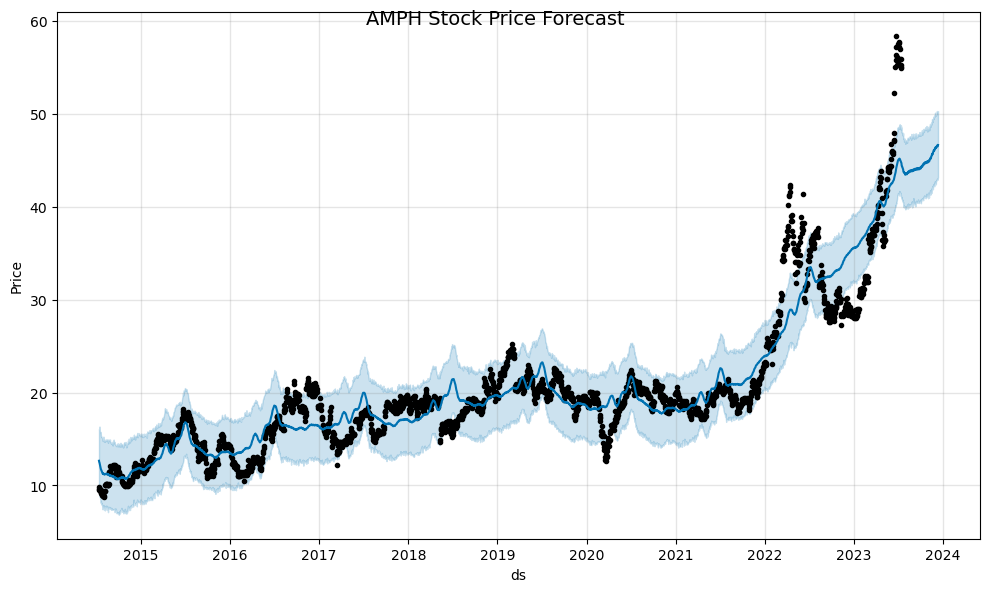

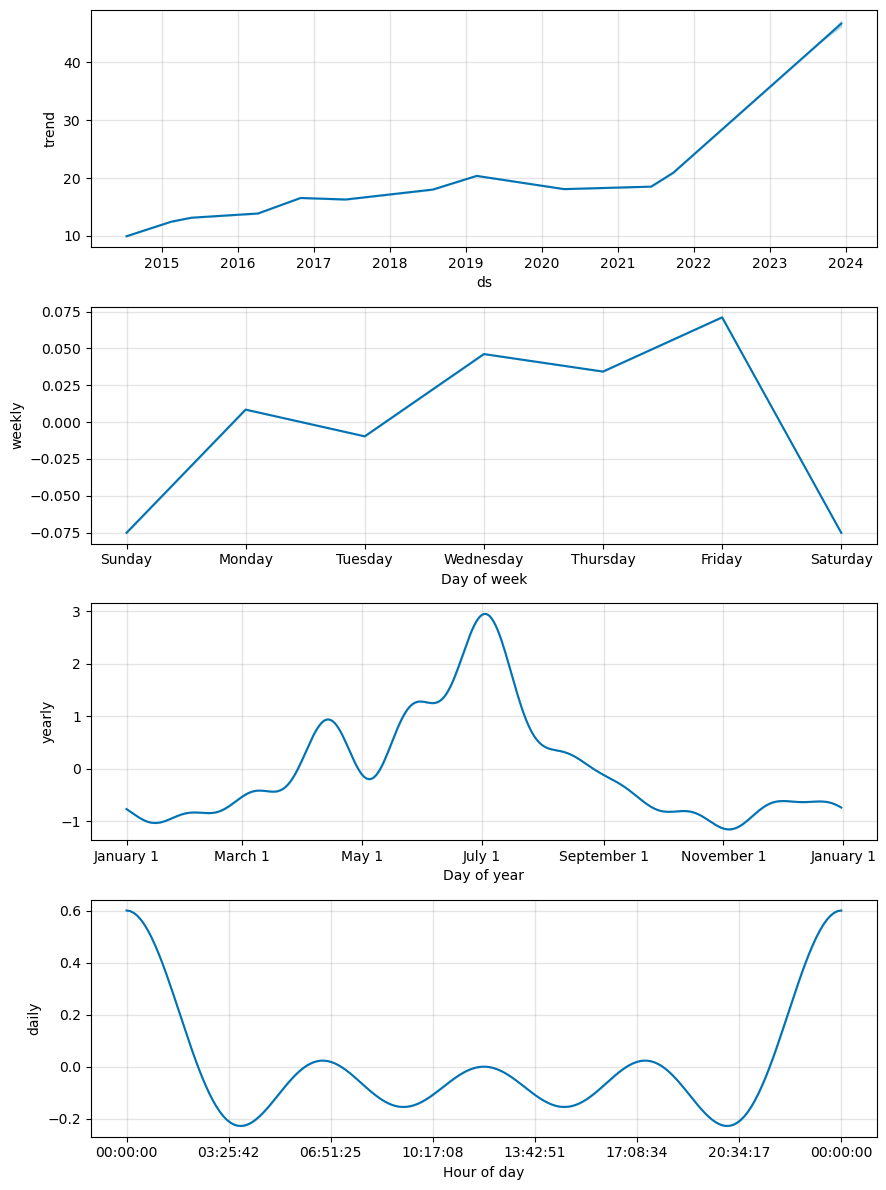

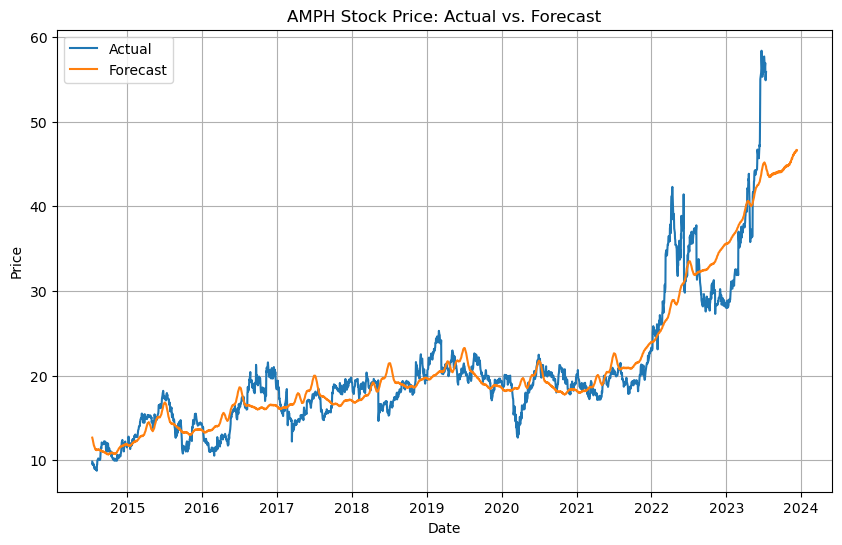

In [20]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prettytable import PrettyTable

# Fixed start and end dates
end_date = pd.to_datetime('today')
start_date = pd.to_datetime('today') - pd.DateOffset(years=9)

# Prompt the user to enter the ticker symbol
tickers = input("Enter ticker symbols (comma-separated): ").split(",")
tickers = [ticker.strip().upper() for ticker in tickers]
# Retrieve the historical data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Reset the index to make the 'Date' column accessible
data.reset_index(inplace=True)

# Select the 'Date' and 'Close' columns for analysis
df = data[['Date', 'Close']].copy()
df.columns = ['ds', 'y']  # Rename columns to 'ds' and 'y'

# Create a Prophet model and fit it to the data
model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.05)
model.fit(df)

# Create future dates for forecasting
future = model.make_future_dataframe(periods=150)

# Perform the forecasting
forecast = model.predict(future)

# Plot the forecasted values
fig1 = model.plot(forecast)
fig1.suptitle(f'{ticker} Stock Price Forecast', fontsize=14)  # Set plot title
fig1.axes[0].set_ylabel('Price')  # Change y-axis label to 'Price'

fig2 = model.plot_components(forecast)

# Calculate forecast accuracy
df_actual = df[['ds', 'y']].copy()
df_actual.columns = ['ds', 'actual']
df_forecast = forecast[['ds', 'yhat']].copy()
df_forecast.columns = ['ds', 'forecast']
df_accuracy = pd.merge(df_actual, df_forecast, on='ds', how='inner')

mae = mean_absolute_error(df_accuracy['actual'], df_accuracy['forecast'])
mse = mean_squared_error(df_accuracy['actual'], df_accuracy['forecast'])
rmse = mean_squared_error(df_accuracy['actual'], df_accuracy['forecast'], squared=False)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Display the forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Get the future dates after today
today = datetime.today().strftime('%Y-%m-%d')
future_dates = forecast[forecast['ds'] > today]

# Get the lowest and highest forecasted points after today
lowest_point = future_dates['yhat_lower'].min()
highest_point = future_dates['yhat_upper'].max()

# Get the date of the lowest and highest forecasted points
lowest_date = future_dates.loc[future_dates['yhat_lower'].idxmin(), 'ds'].strftime('%Y-%m-%d')
highest_date = future_dates.loc[future_dates['yhat_upper'].idxmax(), 'ds'].strftime('%Y-%m-%d')

# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ["Metric", "Value"]

# Add rows to the table
table.add_row(["Mean Absolute Error (MAE)", f"{mae:.2f}"])
table.add_row(["Mean Squared Error (MSE)", f"{mse:.2f}"])
table.add_row(["Root Mean Squared Error (RMSE)", f"{rmse:.2f}"])
table.add_row(["Lowest Forecasted Point (after today)", f"{lowest_point:.2f} on {lowest_date}"])
table.add_row(["Highest Forecasted Point (after today)", f"{highest_point:.2f} on {highest_date}"])

# Print the table
print(table)

# Plot the actual vs. forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price: Actual vs. Forecast')
plt.legend()
plt.grid(True)
plt.show()


**NO TRAIN DATA + OUTLIER REMOVAL**

In [ ]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prettytable import PrettyTable

# Fixed start and end dates
end_date = pd.to_datetime('today')
start_date = pd.to_datetime('today') - pd.DateOffset(years=9)

# Prompt the user to enter the ticker symbol
tickers = input("Enter ticker symbols (comma-separated): ").split(",")
tickers = [ticker.strip().upper() for ticker in tickers]

# Retrieve the historical data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Reset the index to make the 'Date' column accessible
data.reset_index(inplace=True)

# Select the 'Date' and 'Close' columns for analysis
df = data[['Date', 'Close']].copy()
df.columns = ['ds', 'y']  # Rename columns to 'ds' and 'y'

# Remove outliers using z-score
z_scores = (df['y'] - df['y'].mean()) / df['y'].std()
df = df.loc[abs(z_scores) <= 3]

# Create a Prophet model and fit it to the data
model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.05)
model.fit(df)

# Create future dates for forecasting
future = model.make_future_dataframe(periods=365)

# Perform the forecasting
forecast = model.predict(future)

# Plot the forecasted values
fig1 = model.plot(forecast)
fig1.suptitle(f'{ticker} Stock Price Forecast', fontsize=14)  # Set plot title
fig1.axes[0].set_ylabel('Price')  # Change y-axis label to 'Price'

fig2 = model.plot_components(forecast)

# Calculate forecast accuracy
df_actual = df[['ds', 'y']].copy()
df_actual.columns = ['ds', 'actual']
df_forecast = forecast[['ds', 'yhat']].copy()
df_forecast.columns = ['ds', 'forecast']
df_accuracy = pd.merge(df_actual, df_forecast, on='ds', how='inner')

mae = mean_absolute_error(df_accuracy['actual'], df_accuracy['forecast'])
mse = mean_squared_error(df_accuracy['actual'], df_accuracy['forecast'])
rmse = mean_squared_error(df_accuracy['actual'], df_accuracy['forecast'], squared=False)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Display the forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Get the future dates after today
today = datetime.today().strftime('%Y-%m-%d')
future_dates = forecast[forecast['ds'] > today]

# Get the lowest and highest forecasted points after today
lowest_point = future_dates['yhat_lower'].min()
highest_point = future_dates['yhat_upper'].max()

# Get the date of the lowest and highest forecasted points
lowest_date = future_dates.loc[future_dates['yhat_lower'].idxmin(), 'ds'].strftime('%Y-%m-%d')
highest_date = future_dates.loc[future_dates['yhat_upper'].idxmax(), 'ds'].strftime('%Y-%m-%d')

# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ["Metric", "Value"]

# Add rows to the table
table.add_row(["Mean Absolute Error (MAE)", f"{mae:.2f}"])
table.add_row(["Mean Squared Error (MSE)", f"{mse:.2f}"])
table.add_row(["Root Mean Squared Error (RMSE)", f"{rmse:.2f}"])
table.add_row(["Lowest Forecasted Point (after today)", f"{lowest_point:.2f} on {lowest_date}"])
table.add_row(["Highest Forecasted Point (after today)", f"{highest_point:.2f} on {highest_date}"])

# Print the table
print(table)

# Plot the actual vs. forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price: Actual vs. Forecast')
plt.legend()
plt.grid(True)
plt.show()
